# ms2deepscore example additional input values: precursor_mz

In [1]:
from pathlib import Path

from matchms.importing import load_from_mgf
from tensorflow import keras
import pandas as pd

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from ms2deepscore import SpectrumBinner
from ms2deepscore.data_generators import DataGeneratorAllSpectrums
from ms2deepscore.models import SiameseModel
from ms2deepscore import MS2DeepScore

## Data loading

Here we load in a small sample of test spectrum as well as reference scores data.

In [2]:
TEST_RESOURCES_PATH = Path.cwd().parent / 'tests' / 'resources'
spectrums_filepath = str(TEST_RESOURCES_PATH / "pesticides_processed.mgf")
score_filepath = str(TEST_RESOURCES_PATH / "pesticides_tanimoto_scores.json")

Load processed spectrums from .mgf file. For processing itself see [matchms](https://github.com/matchms/matchms) documentation.

In [3]:
spectrums = list(load_from_mgf(spectrums_filepath))

2022-12-05 15:26:57,646:WARNING:matchms:interpret_pepmass:Overwriting existing precursor_mz 183.057 with new one: 183.057
2022-12-05 15:26:57,649:WARNING:matchms:interpret_pepmass:Overwriting existing precursor_mz 208.146 with new one: 208.146
2022-12-05 15:26:57,650:WARNING:matchms:interpret_pepmass:Overwriting existing precursor_mz 370.073 with new one: 370.073
2022-12-05 15:26:57,654:WARNING:matchms:interpret_pepmass:Overwriting existing precursor_mz 231.075 with new one: 231.075
2022-12-05 15:26:57,657:WARNING:matchms:interpret_pepmass:Overwriting existing precursor_mz 246.044 with new one: 246.044
2022-12-05 15:26:57,659:WARNING:matchms:interpret_pepmass:Overwriting existing precursor_mz 282.02 with new one: 282.02
2022-12-05 15:26:57,663:WARNING:matchms:interpret_pepmass:Overwriting existing precursor_mz 292.049 with new one: 292.049
2022-12-05 15:26:57,667:WARNING:matchms:interpret_pepmass:Overwriting existing precursor_mz 211.065 with new one: 211.065
2022-12-05 15:26:57,670:WA

Load reference scores from a .json file. This is a Pandas DataFrame with reference similarity scores (=labels) for compounds identified by inchikeys. Columns and index should be inchikeys, the value in a row x column depicting the similarity score for that pair. Must be symmetric (reference_scores_df[i,j] == reference_scores_df[j,i]) and column names should be identical to the index.

In [4]:
tanimoto_scores_df = pd.read_json(score_filepath)

## Data preprocessing

Bin the spectrums using `ms2deepscore.SpectrumBinner`. In this binned form we can feed spectra to the model.

In [5]:
additional_input=["precursor_mz", "parent_mass"]
spectrum_binner = SpectrumBinner(1000, mz_min=10.0, mz_max=1000.0, peak_scaling=0.5, additional_metadata=additional_input)
binned_spectrums = spectrum_binner.fit_transform(spectrums)

Collect spectrum peaks...
Calculated embedding dimension: 543.
Convert spectrums to binned spectrums...


Create BinnedSpectrum instances: 100%|██████████| 76/76 [00:00<00:00, 6815.19it/s]


In [6]:
binned_spectrums[0].metadata

{'inchikey': 'UYJUZNLFJAWNEZ-UHFFFAOYSA-N'}

Create a data generator that will generate batches of training examples.
Each training example consists of a pair of binned spectra and the corresponding reference similarity score.

In [7]:
dimension = len(spectrum_binner.known_bins)
data_generator = DataGeneratorAllSpectrums(binned_spectrums, tanimoto_scores_df,
                                           dim=dimension, additional_input=additional_input)

## Model training

Initialize a SiameseModel. It consists of a dense 'base' network that produces an embedding for each of the 2 inputs. The 'head' model computes the cosine similarity between the embeddings.

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 543)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 200)               108800    
_________________________________________________________________
normalization1 (BatchNormali (None, 200)               800       
_________________________________________________________________
dense2 (Dense)               (None, 200)               40200     
_________________________________________________________________
normalization2 (BatchNormali (None, 200)               800       
_________________________________________________________________
dropout2 (Dropout)           (None, 200)               0         
_________________________________________________________________
dense3 (Dense)               (None, 200)               40200  

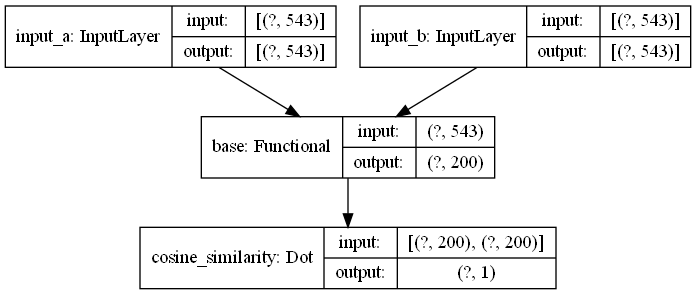

In [8]:
model = SiameseModel(spectrum_binner, base_dims=(200, 200, 200), embedding_dim=200,
                     dropout_rate=0.2, additional_input=len(additional_input))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001))
model.summary()
keras.utils.plot_model(model.model, show_shapes=True)

Train the model on the data, for the sake of simplicity we use the same dataset for training and validation.

In [9]:
model.fit(data_generator,
          validation_data=data_generator,
          epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 183ms/step - loss: 0.0785 - val_loss: 0.0517
Epoch 2/10
2/2 [==============================] - 0s 75ms/step - loss: 0.0988 - val_loss: 0.0720
Epoch 3/10
2/2 [==============================] - 0s 88ms/step - loss: 0.0946 - val_loss: 0.1189
Epoch 4/10
2/2 [==============================] - 0s 70ms/step - loss: 0.0757 - val_loss: 0.1240
Epoch 5/10
2/2 [==============================] - 0s 70ms/step - loss: 0.0650 - val_loss: 0.1958
Epoch 6/10
2/2 [==============================] - 0s 61ms/step - loss: 0.1038 - val_loss: 0.1857
Epoch 7/10
2/2 [==============================] - 0s 59ms/step - loss: 0.0811 - val_loss: 0.1900
Epoch 8/10
2/2 [==============================] - 0s 66ms/step - loss: 0.0818 - val_loss: 0.1983
Epoch 9/10
2/2 [==============================] - 0s 64ms/step - loss: 0.0692 - val_loss: 0.2013
Epoch 10/10
2/2 [==============================] - 0s 63ms/step - loss: 0.0938 - val_loss: 0.2253


## Model inference

Calculate similariteis for a pair of spectra

In [10]:
similarity_measure = MS2DeepScore(model)
score = similarity_measure.pair(spectrums[0], spectrums[1])
print(score)

Create BinnedSpectrum instances: 100%|██████████| 1/1 [00:00<?, ?it/s]


0.9739812391575717


Calculate similarities for a 3x3 matrix of spectra

In [11]:
scores = similarity_measure.matrix(spectrums[:3], spectrums[:3])
print(scores)

Calculating vectors of reference spectrums: 100%|██████████| 3/3 [00:00<00:00, 13.69it/s]


[[1.         0.97398124 0.92202114]
 [0.97398124 1.         0.94127514]
 [0.92202114 0.94127514 1.        ]]
